#### Resources:
- Paul Centore - A Zonohedral Approach to Optimal Colours
(https://legacy.sites.fas.harvard.edu/~cs278/papers/zone.pdf)
- Jessica Lee - Theory of Human Tetrachromatic Color Experience and Printing (https://imjal.github.io/theory-of-tetrachromacy/static/pdfs/Lee_TheoryofTet_v1.pdf)

#### Instructions:
Make sure to install Jessica's repository as a Python package using the line below. It requires Python 3.11.

In [6]:
!pip install -q git+https://github.com/VarunNSrivastava/ChromaLab

In [1]:
from chromalab.observer import Observer
from chromalab.spectra import Spectra, Illuminant
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from tqdm import tqdm
import matplotlib.animation as animation
import pandas as pd
%matplotlib widget

In [116]:
class ObjectColorSolidTrichromat:
    def __init__(self, observer, illuminant, wavelengths, indices=[2,1,0]):
        
        self.rgbcmf = self.loadciergb(wavelengths) # shape (n, 3)
        self.observer = observer # instance of Observer (from chromalab)
        self.illuminant = illuminant # instance of Illuminant (from chromalab)
        self.wavelengths = wavelengths # shape n
        self.coneresponses = np.vstack((self.observer.sensors[indices[0]].data, 
                                        self.observer.sensors[indices[1]].data, 
                                        self.observer.sensors[indices[2]].data
                                        )) # shape (3, n)
        self.numreceptors = self.coneresponses.shape[0]
        self.vertices = self.computeVertexBuffer() # shape (n + 1, n, 3) as described in paul centore paper
        self.faces, self.facecolors = self.computeFacesAndColorsBuffer() # faces: shape (n * (n - 1), 4, 3), face_colors: shape((n * (n - 1), 3))

        
    def computeVertexBuffer(self):
        n = len(self.wavelengths)
        points = np.copy(self.coneresponses).T
        vertices = np.zeros((n + 1, n, 3))
        vertexcolors = np.zeros((n + 1, n, 3))
        for i in range(1, n + 1):
            for j in range(n):
                vertices[i, j] = vertices[i - 1, j] + points[(i + j - 1) % n]
        # normalize all vertices so that whitepoint is (1,1,1); this is based on jessicas paper
        vertices[:,:,0] = vertices[:,:,0] / np.max(vertices[:,:,0])
        vertices[:,:,1] = vertices[:,:,1] / np.max(vertices[:,:,1])
        vertices[:,:,2] = vertices[:,:,2] / np.max(vertices[:,:,2])
        return vertices

    def computeFacesAndColorsBuffer(self):
        n = len(self.wavelengths)
        faces = np.zeros((n * (n - 1), 4, 3))
        face_colors = np.zeros((n * (n - 1), 3))
        for i in tqdm(range(1, n)):
            for j in range(n):
                faces[((i - 1) * n) + j, 0] = self.vertices[i, j]
                faces[((i - 1) * n) + j, 1] = self.vertices[i - 1, (j + 1) % n]
                faces[((i - 1) * n) + j, 2] = self.vertices[i, (j + 1) % n]
                faces[((i - 1) * n) + j, 3] = self.vertices[i + 1, j]
                
                reflectance = np.zeros(n)
                for k in range(i):
                    reflectance[(j + k) % n] = 1
                face_colors[(i - 1) * n + j] = self.coneresponse2rgb(self.vertices[i, j], reflectance)

        print(np.max(face_colors[:,0]))
        print(np.max(face_colors[:,1]))
        print(np.max(face_colors[:,2]))
        # min max normalize
        face_colors[:,0] = (face_colors[:,0] - np.min(face_colors[:,0]))  / (np.max(face_colors[:,0]) - np.min(face_colors[:,0])) 
        face_colors[:,1] = (face_colors[:,1] - np.min(face_colors[:,1]))  / (np.max(face_colors[:,1]) - np.min(face_colors[:,1])) 
        face_colors[:,2] = (face_colors[:,2] - np.min(face_colors[:,2]))  / (np.max(face_colors[:,2]) - np.min(face_colors[:,2])) 
        
        
        return faces, face_colors

    def coneresponse2rgb(self, lmscoord, reflectance):
        objectcolorlms = self.coneresponses * self.illuminant.data * np.vstack((reflectance,reflectance,reflectance))
        A = self.rgbcmf @ objectcolorlms.T @ np.linalg.inv(self.coneresponses @ self.coneresponses.T) # moore penrose
        return A @ lmscoord


    def loadciergb(self, wavelengths):
        df = pd.read_csv('data/sbrgb2.csv') # load ciergb data from stiles and burch 1955 from cvrl website
        ciergb = df.values
        ciewavelengths = ciergb.T[0]
        ciergb = ciergb.T[1:]
        # linearly interpolate to get ciergb in same shape as wavelengths
        ciergbs = np.zeros(shape=(3, len(wavelengths)))
       
        curridx = 0
        for i, wavelength in enumerate(wavelengths[:-2]):
            if ciewavelengths[curridx] + 5 < wavelength:
                curridx += 1
            if wavelength < ciewavelengths[0] or wavelength > ciewavelengths[-1]:
                ciergbs[:,i] = np.array([0,0,0])
            else:
                wavelength1 = ciewavelengths[curridx]
                rgb1 = ciergb[:,curridx]
                rgb2 = ciergb[:,curridx + 1]
                percent = (wavelength - wavelength1) / 5
                ciergbs[:,i] = rgb2 * percent + rgb1 * (1 - percent)
        return ciergbs

    def plot3DColorSolid(self, 
                         title='Object Color Solid with LMS Cone Responses Under a D65 Illuminant',
                         xlabel='L response', 
                         ylabel='M response', 
                         zlabel='S response'):
        plt.clf()
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        poly3d = Poly3DCollection(self.faces, linewidths=0.05, edgecolors='k')
        poly3d.set_facecolor(self.facecolors)
        ax.add_collection3d(poly3d)
        ax.set_title(title)
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        ax.set_zlabel(zlabel)
        plt.savefig('solid_qms_basis.png', dpi=300, bbox_inches='tight')
        plt.show()

    def plotconeresponses(self):
        plt.clf()
        for i in range(self.numreceptors):
            plt.plot(self.wavelengths, self.coneresponses[i], color=(i/3,0,0))
        self.illuminant.plot(color="gray")
        plt.show()
        
    def plotciergb(self):
        plt.clf()
        plt.plot(self.wavelengths, self.rgbcmf[0], color="red")
        plt.plot(self.wavelengths, self.rgbcmf[1], color="green")
        plt.plot(self.wavelengths, self.rgbcmf[2], color="blue") 
        plt.show()
        

100%|█████████████████████| 167/167 [00:00<00:00, 186.27it/s]


1.18653620141
0.888637774258
0.877867278434


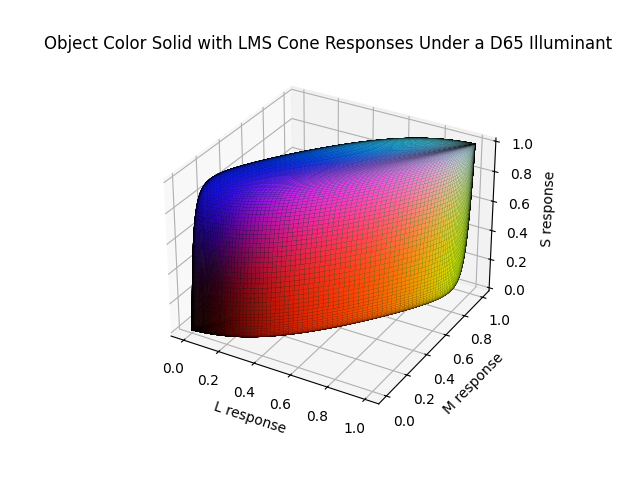

In [107]:
# Cone responses of a typical trichromat.
wavelengths = np.arange(395, 731, 2)
standard_trichromat = Observer.trichromat(wavelengths)
illuminant = Illuminant.get("D65").interpolate_values(wavelengths)

lms = ObjectColorSolidTrichromat(standard_trichromat, illuminant, wavelengths)
lms.plot3DColorSolid()

100%|███████████████████████| 67/67 [00:00<00:00, 339.51it/s]


1.09505856349
0.897386750586
0.879441393138


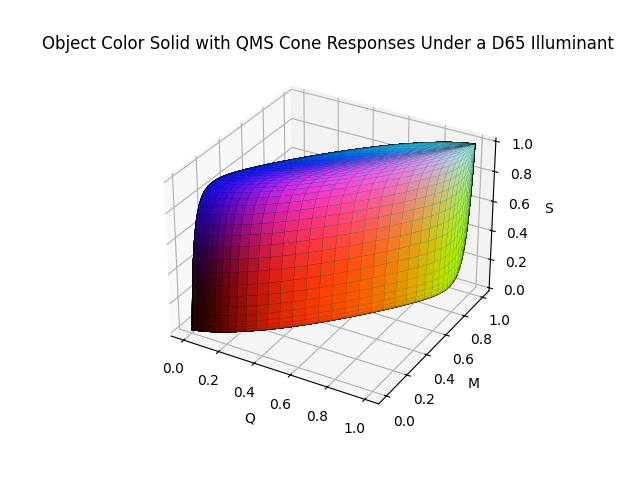

In [118]:
# Cone responses of a typical tetrachromat.
wavelengths = np.arange(395, 731, 5)
standard_tetrachromat = Observer.tetrachromat(wavelengths)
illuminant = Illuminant.get("D65").interpolate_values(wavelengths)
lqm = ObjectColorSolidTrichromat(standard_tetrachromat, illuminant, wavelengths, [2,1,0])
lqm.plot3DColorSolid(title='Object Color Solid with QMS Cone Responses Under a D65 Illuminant', xlabel='Q', ylabel='M', zlabel='S')


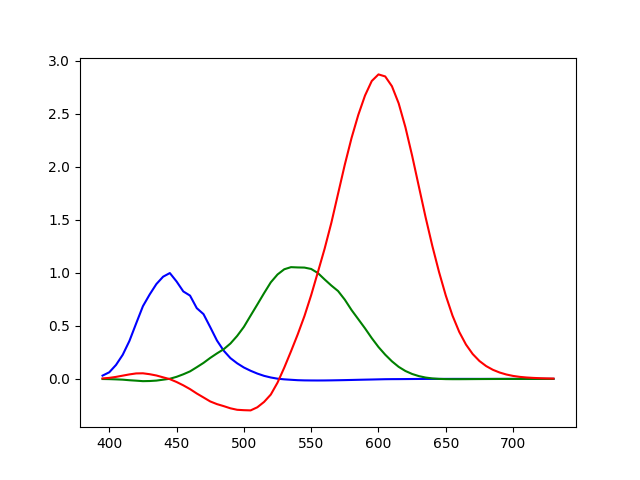

In [89]:
# lqm.plotconeresponses()
lqm.plotciergb()